# Follow-up on CNN filters (kernels)

The CNN filters are *learned* during the training. They are usually initialized as random numbers, and then the filter weights (shared across the image) are updated to achieve the target.

It is interesting to have a look at what the filters are learning from the dataset.

We'll use the `SimpleCNN` we trained in notebook 12.

The first convolutional layer (`conv1`) has 32 filters, each acting on a single input channel (grayscale image). We can directly visualize these `3x3` filters.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the saved model state dictionary
model = SimpleCNN()
model.load_state_dict(torch.load('mnist_cnn.pth'))
model.eval() # Set the model to evaluation mode

print("Model loaded successfully.")

# Get the weights of the first convolutional layer
conv1_weights = model.conv1.weight.data.cpu().numpy()

# Normalize weights for visualization (optional, but often helpful)
# Scale to 0-1 range for better plotting
conv1_weights = (conv1_weights - conv1_weights.min()) / (conv1_weights.max() - conv1_weights.min())

num_filters = conv1_weights.shape[0]
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Filters of Conv1 Layer', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < num_filters:
        # Squeeze the channel dimension (1, 3, 3) -> (3, 3)
        ax.imshow(conv1_weights[i, 0], cmap='gray')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')
    else:
        ax.axis('off') # Hide empty subplots

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Recurrent Neural Networks

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Generate synthetic sine wave data

We'll create a simple sine wave with some noise to simulate realistic time series data.

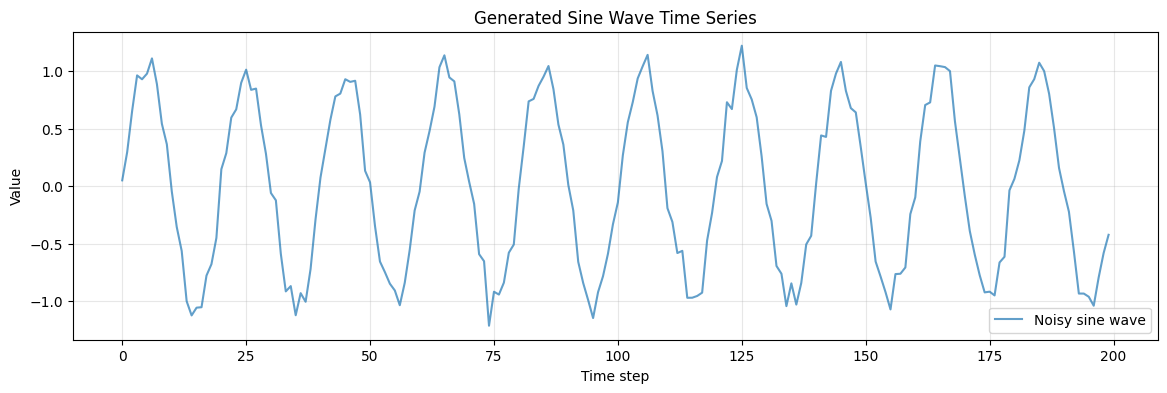

Data shape: (1000,)
Mean: 0.002, Std: 0.712


In [25]:
def generate_sine_wave(n_samples=1000, frequency=0.05,
                       amplitude=1.0, noise_std=0.1):
    """
    Generate a sine wave with Gaussian noise.

    Args:
        n_samples: Number of time steps
        frequency: Frequency of sine wave (controls period)
        amplitude: Amplitude of sine wave
        noise_std: Standard deviation of Gaussian noise

    Returns:
        t: Time array
        y: Noisy sine wave values
    """
    t = np.arange(n_samples)
    y = amplitude * np.sin(2 * np.pi * frequency * t)
    y += np.random.normal(0, noise_std, n_samples)
    return t, y

# Generate data
t, y = generate_sine_wave(n_samples=1000, frequency=0.05,
                          amplitude=1.0, noise_std=0.1)

# Plot the time series
plt.figure(figsize=(14, 4))
plt.plot(t[:200], y[:200], label='Noisy sine wave', alpha=0.7)
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Generated Sine Wave Time Series')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Data shape: {y.shape}")
print(f"Mean: {y.mean():.3f}, Std: {y.std():.3f}")

### Create Sequences for Training

For RNN training, we need to create input sequences and corresponding targets.
- **Input**: Past `seq_length` values: $[y(t-n), ..., y(t-2), y(t-1)]$
- **Target**: Next value: $y(t)$

In [26]:
def create_sequences(data, seq_length):
    """
    Create sequences for RNN training.

    Args:
        data: Time series array
        seq_length: Length of input sequence

    Returns:
        X: Input sequences (n_samples, seq_length, 1)
        y: Target values (n_samples, 1)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 10  # Use past 10 time steps to predict next value
X, y_target = create_sequences(y, seq_length)

# Reshape for RNN input (n_samples, seq_length, n_features)
X = X.reshape(-1, seq_length, 1)
y_target = y_target.reshape(-1, 1)

# Split into train and validation sets (80/20 split)
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y_target[:split_idx], y_target[split_idx:]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

# Convert to PyTorch tensors
X_train_torch = torch.FloatTensor(X_train).to(device)
y_train_torch = torch.FloatTensor(y_train).to(device)
X_val_torch = torch.FloatTensor(X_val).to(device)
y_val_torch = torch.FloatTensor(y_val).to(device)

Training set: (792, 10, 1), (792, 1)
Validation set: (198, 10, 1), (198, 1)


### Create RNN architecture by hand

Let's first implement a very simple RNN cell manually to understand the math:

$$h_t = \tanh(W_x x_t + W_h h_{t-1} + b_h)$$
$$y_t = W_y h_t + b_y$$

In [27]:
class SimpleRNNCell:
    """
    Simple RNN cell implementation in NumPy for educational purposes.
    """
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights with small random values
        scale = 0.01
        self.W_x = np.random.randn(input_size, hidden_size) * scale  # Input to hidden
        self.W_h = np.random.randn(hidden_size, hidden_size) * scale  # Hidden to hidden
        self.W_y = np.random.randn(hidden_size, output_size) * scale  # Hidden to output
        self.b_h = np.zeros((1, hidden_size))  # Hidden bias
        self.b_y = np.zeros((1, output_size))  # Output bias

        self.hidden_size = hidden_size

    def forward(self, X):
        """
        Forward pass through the RNN.

        Args:
            X: Input sequence (seq_length, input_size)

        Returns:
            outputs: Output at each time step
            hidden_states: Hidden states at each time step
        """
        seq_length = X.shape[0]
        hidden_states = []
        outputs = []

        # Initialize hidden state to zeros
        h = np.zeros((1, self.hidden_size))

        # Process sequence one time step at a time
        for t in range(seq_length):
            x_t = X[t:t+1]  # Shape: (1, input_size)

            # Update hidden state: h_t = tanh(W_x * x_t + W_h * h_{t-1} + b_h)
            h = np.tanh(np.dot(x_t, self.W_x) + np.dot(h, self.W_h) + self.b_h)

            # Compute output: y_t = W_y * h_t + b_y
            y = np.dot(h, self.W_y) + self.b_y

            hidden_states.append(h.copy())
            outputs.append(y.copy())

        return np.array(outputs), np.array(hidden_states)

# Test the manual implementation
manual_rnn = SimpleRNNCell(input_size=1, hidden_size=16, output_size=1)
test_input = X_train[0]  # Shape: (10, 1)
outputs, hidden_states = manual_rnn.forward(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Outputs shape: {outputs.shape}")
print(f"Hidden states shape: {hidden_states.shape}")
print(f"\nFinal output (prediction): {outputs[-1, 0, 0]:.4f}")
print(f"True target: {y_train[0, 0]:.4f}")

Input shape: (10, 1)
Outputs shape: (10, 1, 1)
Hidden states shape: (10, 1, 16)

Final output (prediction): -0.0001
True target: -0.0463


### Visualize Hidden State Evolution

Let's see what the hidden state parameters look like before training.

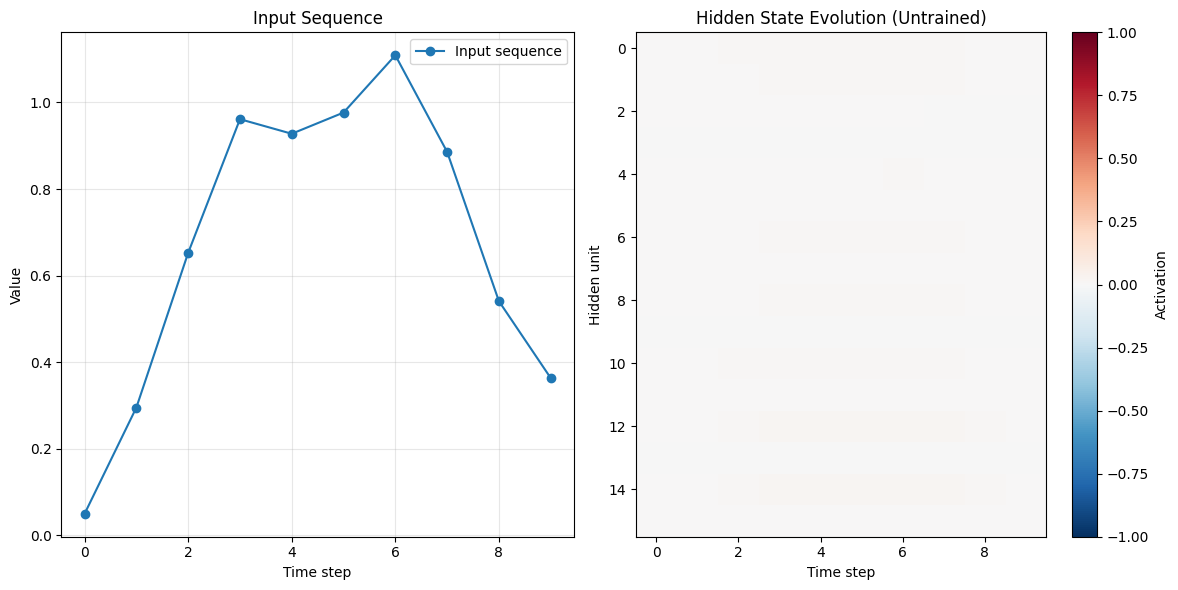

In [28]:
# Plot hidden states over time
hidden_states_reshaped = hidden_states.squeeze()  # Shape: (seq_length, hidden_size)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(test_input, 'o-', label='Input sequence')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Input Sequence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.imshow(hidden_states_reshaped.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Activation')
plt.xlabel('Time step')
plt.ylabel('Hidden unit')
plt.title('Hidden State Evolution (Untrained)')
plt.tight_layout()
plt.show()

This is an UNTRAINED RNN with zero weights, so the hidden states don't encode any meaningful patterns yet.

Key observations:
1. Hidden state dimension: Each row is one of the 16 hidden units
2. Time evolution: Each column is one time step (0-9)
3. Values are zero because we haven't trained yet

After training, we'll see how the network learns to use these hidden units to encode temporal patterns.

### Build and Train RNN with PyTorch

Now let's use PyTorch's built-in RNN for more efficient training. We do not have to keep track of the weights ourselves because PyTorch hides those details.

In [29]:
class VanillaRNN(nn.Module):
    """
    Simple RNN for time series prediction using PyTorch.
    """
    def __init__(self, input_size=1, hidden_size=32, output_size=1, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        # out shape: (batch_size, seq_length, hidden_size)
        # h_n shape: (num_layers, batch_size, hidden_size)
        out, h_n = self.rnn(x, h0)

        # We only need the output from the last time step
        out = self.fc(out[:, -1, :])
        return out, h_n

# Create model
model = VanillaRNN(input_size=1, hidden_size=32, output_size=1, num_layers=1).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

VanillaRNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 1153


### Train the RNN model

What are the `criterion` and `optimizer` being used here?

How does this training loop differ from the DNN and CNN loops we used in previous sessions?

In [30]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, lr=0.001, batch_size=32):
    """
    Train the RNN model.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs, _ = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    return train_losses, val_losses

# Train the model
print("Training RNN...\n")
train_losses, val_losses = train_model(
    model, X_train_torch, y_train_torch, X_val_torch, y_val_torch,
    epochs=100, lr=0.001, batch_size=32
)

Training RNN...

Epoch [10/100], Train Loss: 0.012610, Val Loss: 0.011599
Epoch [20/100], Train Loss: 0.012262, Val Loss: 0.010913
Epoch [30/100], Train Loss: 0.011492, Val Loss: 0.010731
Epoch [40/100], Train Loss: 0.011622, Val Loss: 0.010183
Epoch [50/100], Train Loss: 0.011957, Val Loss: 0.010764
Epoch [60/100], Train Loss: 0.012674, Val Loss: 0.011283
Epoch [70/100], Train Loss: 0.011471, Val Loss: 0.010258
Epoch [80/100], Train Loss: 0.011924, Val Loss: 0.011083
Epoch [90/100], Train Loss: 0.011519, Val Loss: 0.011312
Epoch [100/100], Train Loss: 0.011232, Val Loss: 0.010477


This is an example of using the separate validation dataset to make sure we are not overtraining the model on the training dataset.

After having seen this plot, what would you change about the training?

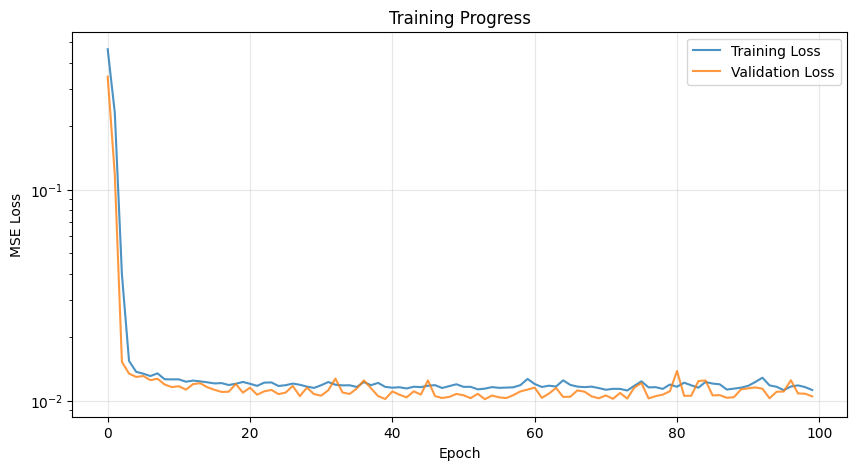

Final Training Loss: 0.011232
Final Validation Loss: 0.010477


In [31]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")

### Inference and visualization

Predict the entire time series given the range of time values (X values).

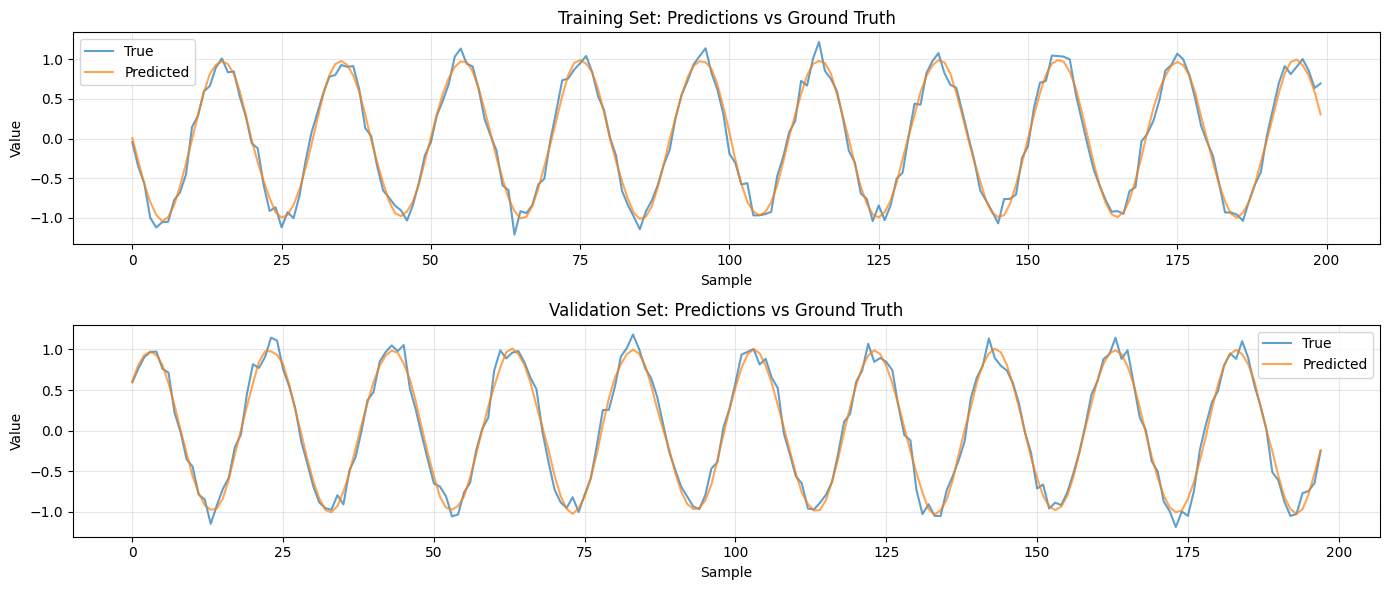


Training Set - MSE: 0.011029
Validation Set - MSE: 0.010477


In [32]:
# Generate predictions
model.eval()
with torch.no_grad():
    train_pred, _ = model(X_train_torch)
    val_pred, _ = model(X_val_torch)

# Convert to numpy for plotting
train_pred = train_pred.cpu().numpy()
val_pred = val_pred.cpu().numpy()

# Plot predictions vs ground truth
plt.figure(figsize=(14, 6))

# Training set predictions
plt.subplot(2, 1, 1)
plt.plot(y_train[:200], label='True', alpha=0.7)
plt.plot(train_pred[:200], label='Predicted', alpha=0.7)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Training Set: Predictions vs Ground Truth')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation set predictions
plt.subplot(2, 1, 2)
plt.plot(y_val, label='True', alpha=0.7)
plt.plot(val_pred, label='Predicted', alpha=0.7)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Validation Set: Predictions vs Ground Truth')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate metrics
train_mse = np.mean((y_train - train_pred)**2)
val_mse = np.mean((y_val - val_pred)**2)

print(f"\nTraining Set - MSE: {train_mse:.6f}")
print(f"Validation Set - MSE: {val_mse:.6f}")

### Visualize the hidden states

What have the RNN's hidden states learned from the data?

Remember that they were all zeroes before training. After training, we see the weights have adapted to the features in the periodic time series data. They have learned what to remember.

In [ ]:
def get_hidden_states(model, X):
    """
    Extract hidden states from RNN for given input.
    """
    model.eval()
    with torch.no_grad():
        # Get all hidden states at each time step
        h0 = torch.zeros(model.num_layers, X.size(0), model.hidden_size).to(X.device)
        rnn_out, _ = model.rnn(X, h0)
    return rnn_out

# Get hidden states for a few validation sequences
sample_indices = [0, 50, 100]

fig, axes = plt.subplots(len(sample_indices), 2, figsize=(14, 4*len(sample_indices)))

for idx, sample_idx in enumerate(sample_indices):
    # Get single sequence
    X_sample = X_val_torch[sample_idx:sample_idx+1]  # Shape: (1, seq_length, 1)
    y_true = y_val[sample_idx, 0]

    # Get hidden states
    hidden_states = get_hidden_states(model, X_sample)
    hidden_states = hidden_states.cpu().numpy().squeeze()  # Shape: (seq_length, hidden_size)

    # Get prediction
    y_pred, _ = model(X_sample)
    y_pred = y_pred.cpu().detach().numpy()[0, 0]

    # Plot input sequence
    axes[idx, 0].plot(X_sample.cpu().numpy().squeeze(), 'o-', label='Input sequence')
    axes[idx, 0].axhline(y=y_true, color='g', linestyle='--', label=f'True next: {y_true:.3f}')
    axes[idx, 0].axhline(y=y_pred, color='r', linestyle='--', label=f'Predicted: {y_pred:.3f}')
    axes[idx, 0].set_xlabel('Time step')
    axes[idx, 0].set_ylabel('Value')
    axes[idx, 0].set_title(f'Sample {sample_idx}: Input Sequence')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)

    # Plot hidden states
    im = axes[idx, 1].imshow(hidden_states.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
    axes[idx, 1].set_xlabel('Time step')
    axes[idx, 1].set_ylabel('Hidden unit')
    axes[idx, 1].set_title(f'Sample {sample_idx}: Hidden State Evolution')
    plt.colorbar(im, ax=axes[idx, 1], label='Activation')

plt.tight_layout()
plt.show()

In particular, we can see
- Different hidden units activate at different times. Some units respond to rising trends, and others to falling trends. The pattern of activations encodes the sequence history
- No single unit stores *the past*. It is distributed across all units.
- The final hidden state (rightmost column) contains compressed info that is used by the output layer to predict the next value.
- Rising sine waves may activate different units than falling ones. This is the *memory* mechanism in RNNs.

In summary, the hidden states compress the past into a fixed-size representation for future prediction.

In [ ]:
!pip install lightning
import torch, torch.nn as nn, torch.utils.data as data, torchvision as tv, torch.nn.functional as F
import lightning as L

# Vanishing Gradients motivate Long Short-Term Networks




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

### Create the Delayed Echo Data

This is a synthetic task designed to test long-term memory:

**Input:** A sequence with a signal (value 1) at an early position, rest are zeros
```
[0, 0, 1, 0, 0, 0, ..., 0, 0, 0] (signal at position 2)
```

**Target:** Echo the signal position after a delay
```
[0, 0, 0, 0, ..., 0, 1, 0, 0, 0]  (echo appears after delay)
```

The network needs to remember the signal position even after many time steps.

First, we need to create the data.

In [33]:
def create_delayed_echo_data(n_samples=1000, seq_length=50, delay=20, signal_position_range=(5, 10)):
    """
    Create delayed echo task dataset.

    Args:
        n_samples: Number of sequences to generate
        seq_length: Total length of each sequence
        delay: Number of steps between signal and echo
        signal_position_range: Range where signal can appear (start, end)

    Returns:
        X: Input sequences (n_samples, seq_length, 1)
        y: Target sequences (n_samples, seq_length, 1)
    """
    X = np.zeros((n_samples, seq_length, 1))
    y = np.zeros((n_samples, seq_length, 1))

    for i in range(n_samples):
        # Randomly place signal
        signal_pos = np.random.randint(signal_position_range[0], signal_position_range[1])
        X[i, signal_pos, 0] = 1.0

        # Place echo after delay
        echo_pos = signal_pos + delay
        if echo_pos < seq_length:
            y[i, echo_pos, 0] = 1.0

    return X, y

# Create datasets with different delay lengths
delays = [20, 40, 60]
datasets = {}

for delay in delays:
    X, y = create_delayed_echo_data(n_samples=1000, seq_length=80, delay=delay)

    # Split into train/val
    split = int(0.8 * len(X))
    datasets[delay] = {
        'X_train': torch.FloatTensor(X[:split]).to(device),
        'y_train': torch.FloatTensor(y[:split]).to(device),
        'X_val': torch.FloatTensor(X[split:]).to(device),
        'y_val': torch.FloatTensor(y[split:]).to(device)
    }

print(f"Created datasets for delays: {delays}")
print(f"Sequence length: 50")
print(f"Training samples per delay: 800")
print(f"Validation samples per delay: 200")

Created datasets for delays: [20, 40, 60]
Sequence length: 50
Training samples per delay: 800
Validation samples per delay: 200


### Visualize the data

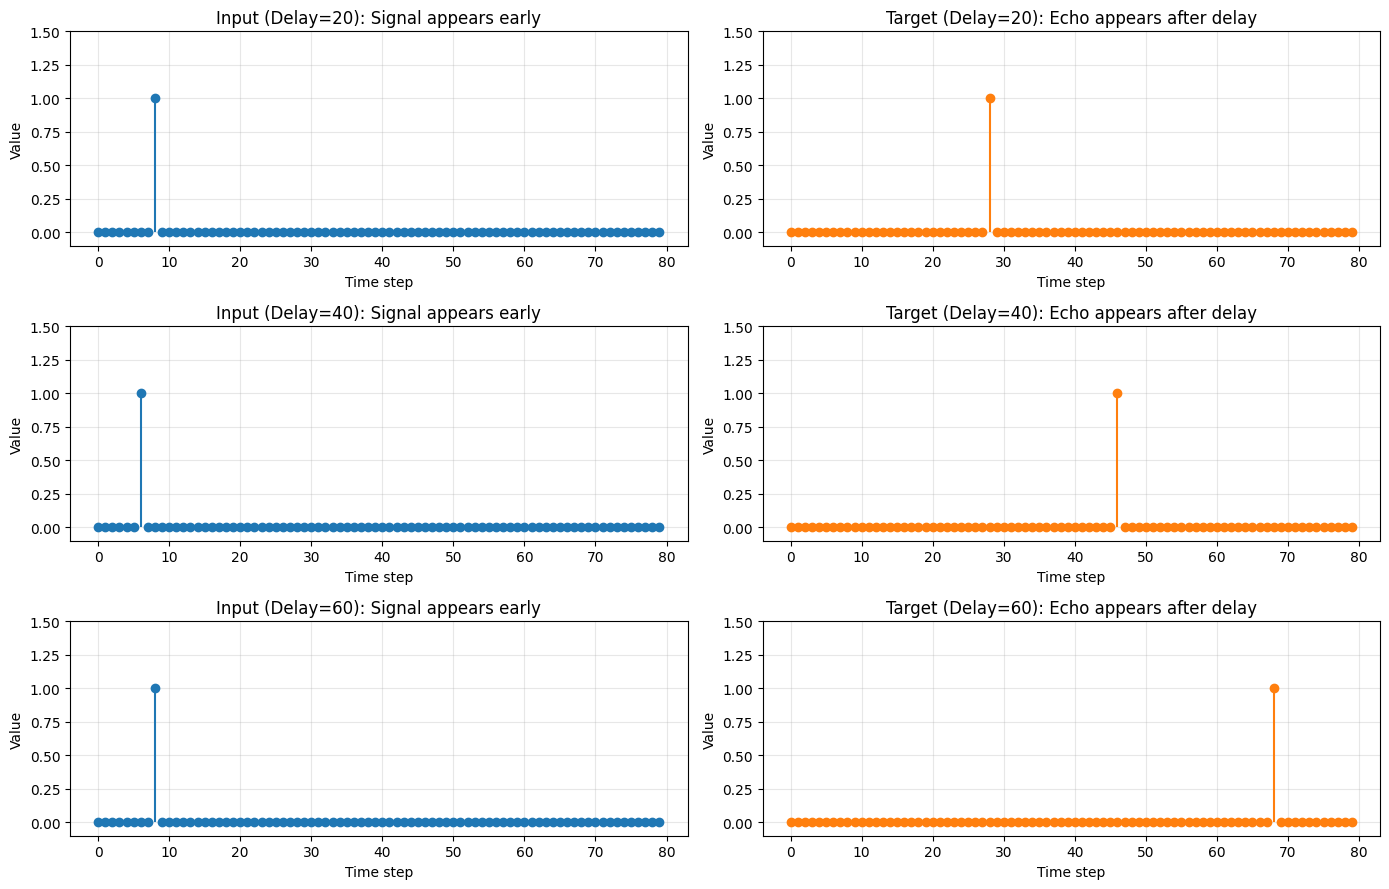

In [34]:
# Show examples for each delay
fig, axes = plt.subplots(len(delays), 2, figsize=(14, 3*len(delays)))

for idx, delay in enumerate(delays):
    X_example = datasets[delay]['X_train'][0].cpu().numpy().squeeze()
    y_example = datasets[delay]['y_train'][0].cpu().numpy().squeeze()

    # Plot input
    axes[idx, 0].stem(X_example, basefmt=' ')
    axes[idx, 0].set_ylim(-0.1, 1.5)
    axes[idx, 0].set_xlabel('Time step')
    axes[idx, 0].set_ylabel('Value')
    axes[idx, 0].set_title(f'Input (Delay={delay}): Signal appears early')
    axes[idx, 0].grid(True, alpha=0.3)

    # Plot target
    axes[idx, 1].stem(y_example, basefmt=' ', linefmt='C1-', markerfmt='C1o')
    axes[idx, 1].set_ylim(-0.1, 1.5)
    axes[idx, 1].set_xlabel('Time step')
    axes[idx, 1].set_ylabel('Value')
    axes[idx, 1].set_title(f'Target (Delay={delay}): Echo appears after delay')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


We want to train a network to remember where the signal appeared and echo it after the delay.

Obviously this will require maintaining information across many time steps.

### Train the vanilla RNN using simple architecture

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, h_n = self.rnn(x, h0)
        # Output at all time steps (not just last)
        out = self.fc(out)
        return out

def train_echo_model(model, X_train, y_train, X_val, y_val, epochs=50, lr=0.001):
    """
    Train model on delayed echo task.
    """
    criterion = nn.BCEWithLogitsLoss()  # Binary classification at each time step
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

            # Calculate accuracy (correct echo detection)
            predictions = (torch.sigmoid(val_outputs) > 0.5).float()
            accuracy = (predictions == y_val).float().mean().item()
            val_accuracies.append(accuracy)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, "
                  f"Val Loss: {val_loss.item():.4f}, Val Acc: {accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

# Train vanilla RNN on all delays
vanilla_results = {}

for delay in delays:
    print(f"\n{'='*60}")
    print(f"Training Vanilla RNN with delay={delay}")
    print('='*60)

    model = VanillaRNN(input_size=1, hidden_size=64, output_size=1).to(device)

    train_losses, val_losses, val_accs = train_echo_model(
        model,
        datasets[delay]['X_train'], datasets[delay]['y_train'],
        datasets[delay]['X_val'], datasets[delay]['y_val'],
        epochs=50, lr=0.001
    )

    vanilla_results[delay] = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accs,
        'final_accuracy': val_accs[-1]
    }

### Analyze the vanilla RNN performance



In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
for delay in delays:
    axes[0].plot(vanilla_results[delay]['val_losses'], label=f'Delay={delay}', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Vanilla RNN: Loss vs Delay Length')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
for delay in delays:
    axes[1].plot(vanilla_results[delay]['val_accuracies'], label=f'Delay={delay}', alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Vanilla RNN: Accuracy vs Delay Length')
axes[1].axhline(y=0.98, color='gray', linestyle='--', alpha=0.5, label='98% threshold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Validation Accuracies (Vanilla RNN):")
for delay in delays:
    acc = vanilla_results[delay]['final_accuracy']
    print(f"  Delay={delay}: {acc:.4f} ({acc*100:.1f}%)")

We might have expected the RNN to do worse as the delay increases, but this is actually pretty good!

In [ ]:
def compute_gradient_norms(model, X, y, criterion):
    """
    Compute gradient norms at different time steps.
    """
    model.train()

    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Collect gradient norms
    grad_norms = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norms.append(param.grad.norm().item())

    return grad_norms

# Compute gradients for different delays
criterion = nn.BCEWithLogitsLoss()

plt.figure(figsize=(10, 6))

for delay in delays:
    model = vanilla_results[delay]['model']
    X_sample = datasets[delay]['X_val'][:10]
    y_sample = datasets[delay]['y_val'][:10]

    grad_norms = compute_gradient_norms(model, X_sample, y_sample, criterion)
    plt.plot(grad_norms, 'o-', label=f'Delay={delay}', alpha=0.7)

plt.xlabel('Parameter Index')
plt.ylabel('Gradient Norm')
plt.title('Vanilla RNN: Gradient Magnitudes by Delay')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Analysis

We expected there to be some vanishing gradient as a function of delay, but these gradients do not seem to be vanishing.

Nevertheless we'll implement the LSTM as an alternative model for this application.

Two questions:
- How is the LSTM architecture definition different from the RNN definition?
- How is the LSTM training loop different from the RNN training loop?

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

# Train LSTM on all delays
lstm_results = {}

for delay in delays:
    print(f"\n{'='*60}")
    print(f"Training LSTM with delay={delay}")
    print('='*60)

    model = LSTMModel(input_size=1, hidden_size=64, output_size=1).to(device)

    train_losses, val_losses, val_accs = train_echo_model(
        model,
        datasets[delay]['X_train'], datasets[delay]['y_train'],
        datasets[delay]['X_val'], datasets[delay]['y_val'],
        epochs=50, lr=0.001
    )

    lstm_results[delay] = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accs,
        'final_accuracy': val_accs[-1]
    }

### Evaluate the performance of the LSTM

In [ ]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
for delay in delays:
    axes[0].plot(vanilla_results[delay]['val_accuracies'],
                 label=f'RNN (delay={delay})', alpha=0.5, linestyle='--')
    axes[0].plot(lstm_results[delay]['val_accuracies'],
                 label=f'LSTM (delay={delay})', alpha=0.8)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Accuracy: LSTM vs Vanilla RNN')
axes[0].axhline(y=0.98, color='gray', linestyle=':', alpha=0.5)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar chart of final accuracies
x_pos = np.arange(len(delays))
width = 0.35

vanilla_accs = [vanilla_results[d]['final_accuracy'] for d in delays]
lstm_accs = [lstm_results[d]['final_accuracy'] for d in delays]

axes[1].bar(x_pos - width/2, vanilla_accs, width, label='Vanilla RNN', alpha=0.7)
axes[1].bar(x_pos + width/2, lstm_accs, width, label='LSTM', alpha=0.7)

axes[1].set_xlabel('Delay Length')
axes[1].set_ylabel('Final Validation Accuracy')
axes[1].set_title('Final Performance: LSTM vs Vanilla RNN')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(delays)
axes[1].axhline(y=0.98, color='gray', linestyle=':', alpha=0.5)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"\n{'Delay':<10} {'Vanilla RNN':<15} {'LSTM':<15} {'Improvement'}")
print("-"*60)
for delay in delays:
    v_acc = vanilla_results[delay]['final_accuracy']
    l_acc = lstm_results[delay]['final_accuracy']
    improvement = ((l_acc - v_acc) / v_acc * 100) if v_acc > 0 else float('inf')
    print(f"{delay:<10} {v_acc:<15.4f} {l_acc:<15.4f} {improvement:>+.1f}%")
